# Closure test and toy model

In this notebook we implement the results presented in the notes about the polynomial toy model.
The idea should be that of applying a level-2 closure test using a polynomial low to generate fake data, and again a polynomial law with higher degree to fit them.

In [1]:
import copy
from math import sqrt

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt

from nb_functions import generate_noise, generate_x, generate_hoc, fit_law, generate_y, tv_split

Define the number of fake esperimental point to be taken, the error over each of them and the region of x we want to consider.
Choose the underlying law you want to use to generate fake data. 

In [2]:
#number of experimental points
#N_x = 100

#error over them, for now the same for all the points
#sigma = 0.1

#x_i = 0.4  # let's take x_min > 0 to modelize a low-x extrapolation region 
#x_f = 1
x_seed, noise_seed = 123, 456
N_x, sigma, x_i, x_f, N_law = 100, 0.1, 0.4, 1, 2
#y = c[0]x + c[1] linear law
c = np.ones(N_law)

Define the experimental points x

(0, 1)

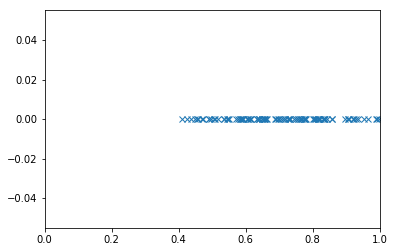

In [3]:
np.random.seed(x_seed)
x =  x_i + np.random.rand(N_x)*(x_f-x_i)
plt.plot(x, np.zeros_like(x), 'x')
plt.xlim(0, 1)


Define the degree of the polynomial to be use as model to fit and the number of replicas.

In [4]:
#degree of the polynomial function used to fit
N_model = 2

#number of replicas
N_rep = 5


In [5]:
#level-1 randoom noise, same for every replicas
N_max = max([N_model, N_law])
ho_c = np.zeros(N_x)
for i in range(N_model, N_max):
    ho_c += c[i]*x**i

np.random.seed(noise_seed)
eta = sigma*np.random.randn(N_x)
eta_rep = np.zeros((N_x, N_rep))

for k in range(N_rep):
    eta_rep[:,k] = eta + ho_c

#lvel-2 noise
delta = sigma*np.random.randn(N_x, N_rep)

#total error for each replicas
e_rep = eta_rep + delta 

Define the matrix of the moments A^(-1) and the vector v according to the equations below.

In [6]:
%%latex
$$v=E\left[\eta x^{i}\right]$$
$$ (A^{-1})_{ij}= E\left[x^{i+j}\right]$$


<IPython.core.display.Latex object>

In [7]:
#matrix of moments & vector of moments

A_inverse = np.zeros((N_model, N_model))
v = np.zeros((N_model, N_rep))
v_exact = np.zeros((N_model))

for k in range(N_rep):
    for i in range(N_model):
        v_exact[i] = ((eta + ho_c)*(x**(i))).mean()
        v[i][k] = (e_rep[:,k]*(x**(i))).mean()
        for j in range(N_model):
            A_inverse[i, j] = (x**(i+j)).mean()

In order to find the solution of the system we need to invert the matrix using the function inv.
Playing a bit with the code one can see that incresing too much the N_model parameters, this matrix is no more positive according to python..not sure if this is a numerical issue or if at some point the matrix is no more invertible..

In [8]:
#is the linear system solvable?
np.all(np.linalg.eigvals(A_inverse) > 0)

True

In [9]:
#implement the solution of the linear sistem
#gamma_i = A_ij v_j + c_i

#inverte the matrix in order to have the one giving the solution if the linear system
A = inv(A_inverse)
#construct c
N_c = min(N_law, N_model)
c_padded = np.zeros(N_model)
c_padded[:N_c] = c[:N_c]

c_rep = np.zeros((N_model, N_rep))
for k in range(N_rep):
    c_rep[:,k] = c_padded


In the notes we claim that the matrix A is positive definite.
Let's check this explicitly here using numpy

In [10]:
np.all(np.linalg.eigvals(A) > 0)

True

In [11]:
#solution of the linear system
gamma = np.matmul(A, v) + c_rep
print(gamma)

[[1.01867051 1.00520272 1.07388231 1.05614014 1.13542533]
 [0.97961361 1.01074181 0.8997141  0.95105228 0.83704097]]


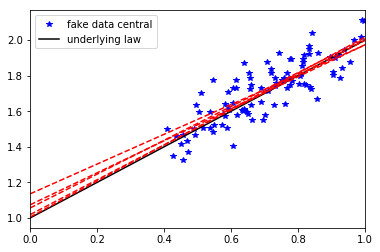

In [12]:
x_interpolate = np.linspace(0, x_f, 200)
y_fakedata = copy.deepcopy(eta)
y_underlyinglaw = np.zeros(x_interpolate.shape)

for i in range(N_law):
    y_fakedata += c[i]*x**i
    y_underlyinglaw += c[i]*x_interpolate**i

y_fitted = np.zeros((200, N_rep))

for k in range(N_rep):
    for i in range(N_model):
        y_fitted[:,k] += gamma[i][k]*x_interpolate**i
         
plt.figure()
plt.plot(x, y_fakedata, '*b', label='fake data central')
plt.plot(x_interpolate, y_underlyinglaw, '-k',
         label='underlying law')
plt.plot(x_interpolate, y_fitted, '--r')
plt.xlim(0,x_f)
plt.legend()
plt.show()

From the notes we know that Var(gamma_i) is given by sigma^2 A_ii.
In particular Var(gamma_0) = sigma^2 A_00. This is what we are interested in when looking at the error in the extrapolation region.

In [13]:
print(sigma*sigma/N_x*A[0][0])
print(gamma[0].std()**2)

0.0023660803318601166
0.0021169318217445204


In [14]:
deltachi2 = -np.matmul(v_exact,np.matmul(A, v_exact))/(sigma*sigma)
print(deltachi2)

-0.022047359499511924


In [15]:
model_slider = widgets.IntSlider(min=2,max=10,step=1,value=2)
law_slider = widgets.IntSlider(min=2,max=10,step=1,value=2)
Nx_slider = widgets.IntSlider(min=2,max=300,step=1,value=100)
level_slider = widgets.IntSlider(min=1,max=2,step=1,value=2)
rep_slider = widgets.IntSlider(min=1,max=100,step=1,value=10)
sigma_slider = widgets.FloatSlider(min=0.0, max=0.5, step=0.05, value=0.1)
xi_slider = widgets.FloatSlider(min=0.0, max=1, step=0.1, value=0.4)
xf_slider = widgets.FloatSlider(min=0.4, max=5.0, step=0.1, value=1.0)

def update_xi_range(*args):
    xi_slider.max = xf_slider.value - xi_slider.step
xf_slider.observe(update_xi_range, 'value')
def update_xf_range(*args):
    xf_slider.min = xi_slider.value + xf_slider.step
xi_slider.observe(update_xf_range, 'value')

def plot_fit(N_model, N_law, N_x, level, N_rep, sigma, x_i, x_f, x_seed, noise_seed):
    N_int = 200
    x = generate_x(N_x, x_i, x_f, x_seed=x_seed)
    noise = generate_noise(sigma, N_x, N_rep, level=level, noise_seed=noise_seed)
    eta_ = generate_noise(sigma, N_x, 1, level=1, noise_seed=noise_seed)
    hoc = generate_hoc(x, N_model, N_law, N_rep)
    gamma = fit_law(x, noise, hoc, N_model, N_law)
    x_interpolate = np.linspace(0, x_f, 200)
    y_fakedata = generate_y(x, np.ones(N_law)) + eta_[:, 0]
    y_underlyinglaw = generate_y(x_interpolate, np.ones(N_law))
    y_fitted = np.zeros((200, N_rep))
    for k in range(N_rep):
        y_fitted[:,k] = generate_y(x_interpolate, gamma[:, k])
    plt.figure()
    plt.plot(x, y_fakedata, '*b', label='fake data central')
    plt.plot(x_interpolate, y_underlyinglaw, '-k',
         label='underlying law')
    plt.plot(x_interpolate, y_fitted, '--r')
    plt.xlim(0,x_f)
    plt.legend()
    plt.show()

    
interactive_plot = interactive(plot_fit, N_model=model_slider, N_law=law_slider, N_x=Nx_slider, level=level_slider,
                                N_rep=rep_slider, sigma=sigma_slider, x_i=xi_slider, x_f=xf_slider, 
                                x_seed=fixed(x_seed), noise_seed=fixed(noise_seed))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot


interactive(children=(IntSlider(value=2, description='N_model', max=10, min=2), IntSlider(value=2, description…

Now we should try doing a training/validation split, can begin by minimising on both sets analytically. Since data is generated uniformly, we can take the first half as training data and the second half as validation.

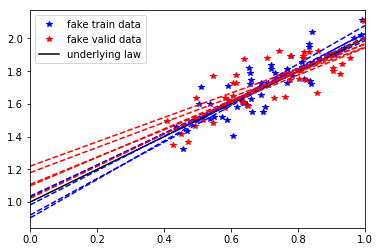

In [16]:
x_total = generate_x(N_x, x_i, x_f, x_seed=x_seed)
noise = generate_noise(sigma, N_x, N_rep, level=2, noise_seed=noise_seed)
eta_ = generate_noise(sigma, N_x, 1, level=1, noise_seed=noise_seed)
hoc = generate_hoc(x_total, N_model, N_law, N_rep)

x_train = x_total[:int(N_x/2)]
x_valid = x_total[int(N_x/2):]
n_train = noise[:int(N_x/2)]
n_valid = noise[int(N_x/2):]
e_train = eta_[:int(N_x/2)]
e_valid = eta_[int(N_x/2):]
h_train = hoc[:int(N_x/2)]
h_valid = hoc[int(N_x/2):]

g_train = fit_law(x_train, n_train, h_train, N_model, N_law)
g_valid = fit_law(x_valid, n_valid, h_valid, N_model, N_law)

x_interpolate = np.linspace(0, x_f, 200)

y_faket = generate_y(x_train, np.ones(N_law)) + e_train[:, 0]
y_fakev = generate_y(x_valid, np.ones(N_law)) + e_valid[:, 0]

y_underlyinglaw = generate_y(x_interpolate, np.ones(N_law))
y_t = np.zeros((200, N_rep))
for k in range(N_rep):
    y_t[:,k] = generate_y(x_interpolate, g_train[:, k])
y_v = np.zeros((200, N_rep))
for k in range(N_rep):
    y_v[:,k] = generate_y(x_interpolate, g_valid[:, k])

plt.figure()
plt.plot(x_train, y_faket, '*b', label='fake train data')
plt.plot(x_valid, y_fakev, '*r', label='fake valid data')
plt.plot(x_interpolate, y_underlyinglaw, '-k',
     label='underlying law')
plt.plot(x_interpolate, y_t, '--b')
plt.plot(x_interpolate, y_v, '--r')
plt.xlim(0,x_f)
plt.legend()
plt.show()

We can go back to the original expression for chi^2 and calculate the gradient with respect to each parameter
and then do a numerical update, on level 1 data only

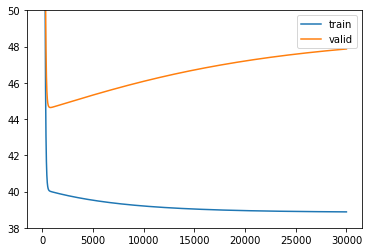

822


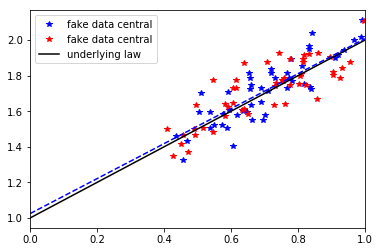

In [17]:
g_bestfit = fit_law(x_train, e_train, h_train, N_model, N_law)
y_bestt = generate_y(x_train, g_bestfit)
steps = 30000
gamma_t = np.random.rand(N_model) + 0.5
y_train = generate_y(x_train, gamma_t)
chi2 = np.zeros(steps)
chi2_valid = np.zeros(steps)
gamma_hist = np.zeros((steps, N_model))
grad_chi2 = np.zeros(N_model)
lr = 0.0000005

for k in range(steps):
    for i in range(N_model):
        grad_chi2[i] = np.sum(-2*(x_train**(i))*(y_faket - y_train))/(sigma**2)
    gamma_t -= lr*grad_chi2
    y_train = generate_y(x_train, gamma_t)
    chi2[k] = np.sum((y_faket - y_train)**2)/(sigma**2)
    y_valid = generate_y(x_valid, gamma_t)
    chi2_valid[k] = np.sum((y_fakev - y_valid)**2)/(sigma**2)
    gamma_hist[k, :] = gamma_t
lookback = np.argmin(chi2_valid)
gamma_lookback = gamma_hist[lookback, :]
plt.figure()
plt.plot(chi2, label='train')
plt.plot(chi2_valid, label='valid')
plt.ylim(38, 50)
plt.legend()
plt.show()
print(lookback)
y_fitted = generate_y(x_interpolate, gamma_lookback)
plt.figure(1)
plt.plot(x_train, y_faket, '*b', label='fake data central')
plt.plot(x_valid, y_fakev, '*r', label='fake data central')
plt.plot(x_interpolate, y_underlyinglaw, '-k',
     label='underlying law')
plt.plot(x_interpolate, y_fitted, '--b')
plt.xlim(0,x_f)
plt.legend()
plt.show()

For repeating the exercise on extra replicas, we need to be able to shuffle the training validation sets. The
selection will now be done randomly, I may wish to seed this in the future to certify results.

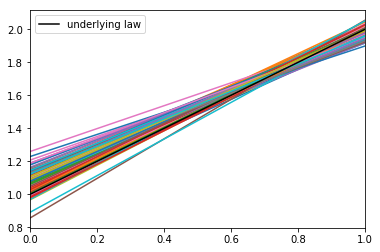

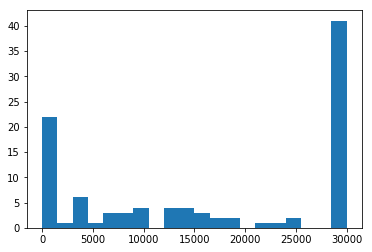

In [18]:
N_rep = 100
x_total = generate_x(N_x, x_i, x_f, x_seed=None)
noise = generate_noise(sigma, N_x, N_rep, level=2, noise_seed=noise_seed)
chi2_fullfit = np.zeros((N_rep, steps))
chi2_v_fullfit = np.zeros((N_rep, steps))
gamma_hist_fullfit = np.zeros((N_rep, steps, N_model))
y_plotrep = np.zeros((x_interpolate.shape[0], N_rep))
y_data_lb = np.zeros((N_x, N_rep))
lookback_hist = np.zeros(N_rep)
plt.figure()

for k in range(N_rep):
    np.random.seed(None)
    i_t, i_v = tv_split(N_x)
    y_fake = generate_y(x_total, np.ones(N_law)) + noise[:, k]
    gamma_fullfit = np.random.rand(N_model) + 0.5
    y_fit = generate_y(x_total, gamma_fullfit) 
    for i in range(steps):
        for j in range(N_model):
            grad_chi2[j] = np.sum(-2*(x_total[i_t]**(j))*(y_fake[i_t] - y_fit[i_t]))/(sigma**2)
        gamma_fullfit -= lr*grad_chi2
        y_fit = generate_y(x_total, gamma_fullfit)
        chi2_fullfit[k, i] = np.sum((y_fake[i_t] - y_fit[i_t])**2)/(sigma**2)
        y_valid = generate_y(x_valid, gamma_fullfit)
        chi2_v_fullfit[k, i] = np.sum((y_fake[i_v] - y_fit[i_v])**2)/(sigma**2)
        gamma_hist_fullfit[k, i, :] = gamma_fullfit
    lookback = np.argmin(chi2_v_fullfit[k, :])
    lookback_hist[k] = lookback
    y_plotrep[:, k] = generate_y(x_interpolate, gamma_hist_fullfit[k, lookback, :])
    y_data_lb[:, k] = generate_y(x_total, gamma_hist_fullfit[k, lookback, :])
plt.plot(x_interpolate, y_plotrep, '-')
lookback_full = np.argmin(chi2_v_fullfit, axis=1)
plt.plot(x_interpolate, y_underlyinglaw, '-k', label='underlying law')
plt.xlim(0, x_f)
plt.legend()
plt.show()

plt.figure()
plt.hist(lookback_hist, bins=20)
plt.show()

In [19]:
y_lvlone = generate_y(x_total, np.ones(N_law)) + generate_noise(sigma, N_x, 1, level=1, noise_seed=noise_seed)
y_lvlzero = generate_y(x_total, np.ones(N_law))
y_central = y_data_lb.mean(axis=1)
    
chi2_central = np.sum((y_lvlone - y_central)**2)/(sigma**2)
chi2_in = np.sum((y_lvlone - y_lvlzero)**2)/(sigma**2)

(chi2_central - chi2_in)/chi2_in

0.02113434219988653

We should bootstrap deltachi2 across replicas to get an idea of the stability of the result

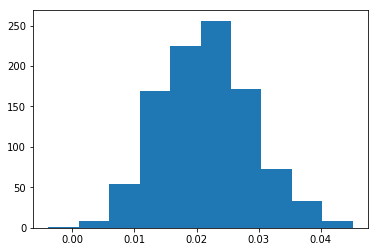

In [20]:
N_boot = 1000
delta_chi2_boot = np.zeros(N_boot)
for i in range(N_boot):
    y_boot = y_data_lb[:, np.random.randint(0, N_rep, size=N_rep)].mean(axis=1)
    chi2_central_boot = np.sum((y_lvlone - y_boot)**2)/(sigma**2)
    delta_chi2_boot[i] = (chi2_central_boot - chi2_in)/chi2_in
plt.figure()
plt.hist(delta_chi2_boot)
plt.show()

Now we want to see what happens when we just do a fit without using cross validation

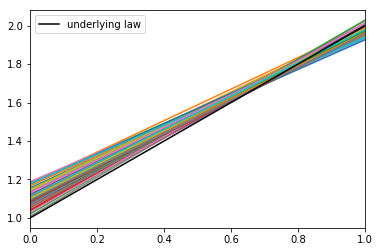

In [21]:
gamma_nocross = np.zeros((N_rep, N_model))
y_plotrep_nocross = np.zeros((x_interpolate.shape[0], N_rep))
y_data_lb_nocross = np.zeros((N_x, N_rep))
for k in range(N_rep):
    y_fake = generate_y(x_total, np.ones(N_law)) + noise[:, k]
    np.random.seed(None)
    gamma_fullfit = np.random.rand(N_model) + 0.5
    y_fit = generate_y(x_total, gamma_fullfit) 
    for i in range(steps):
        for j in range(N_model):
            grad_chi2[j] = np.sum(-2*(x_total**(j))*(y_fake - y_fit))/(sigma**2)
        gamma_fullfit -= lr*grad_chi2
        y_fit = generate_y(x_total, gamma_fullfit)
    gamma_nocross[k, :] = gamma_fullfit
    y_plotrep_nocross[:, k] = generate_y(x_interpolate, gamma_nocross[k, :])
    y_data_lb_nocross[:, k] = generate_y(x_total, gamma_nocross[k, :])
plt.plot(x_interpolate, y_plotrep_nocross, '-')
plt.plot(x_interpolate, y_underlyinglaw, '-k', label='underlying law')
plt.xlim(0, x_f)
plt.legend()
plt.show()

In [22]:
y_central_nocross = y_data_lb_nocross.mean(axis=1)
    
chi2_central_nocross = np.sum((y_lvlone - y_central_nocross)**2)/(sigma**2)
(chi2_central_nocross - chi2_in)/chi2_in

0.042593989936665536

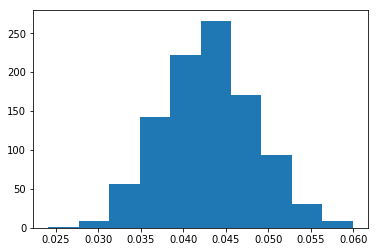

In [23]:
N_boot = 1000
delta_chi2_boot = np.zeros(N_boot)
for i in range(N_boot):
    y_boot = y_data_lb_nocross[:, np.random.randint(0, N_rep, size=N_rep)].mean(axis=1)
    chi2_central_boot = np.sum((y_lvlone - y_boot)**2)/(sigma**2)
    delta_chi2_boot[i] = (chi2_central_boot - chi2_in)/chi2_in
plt.figure()
plt.hist(delta_chi2_boot)
plt.show()